5 (optional) train cifar10 on resnet(~epoch) if you have GPU. Build the training script from week2

In [1]:
import mxnet as mx 
from importlib import import_module
import cv2
import matplotlib.pyplot as plt 
import numpy as np 

Download Pre-trained RESNET 50 from Internet

In [7]:
# reference: https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
import os, urllib
def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.urlretrieve(url, filename)
def get_model(prefix, epoch):
    download(prefix+'-symbol.json')
    download(prefix+'-%04d.params' % (epoch,))

get_model('http://data.mxnet.io/models/imagenet/resnet/50-layers/resnet-50', 0)

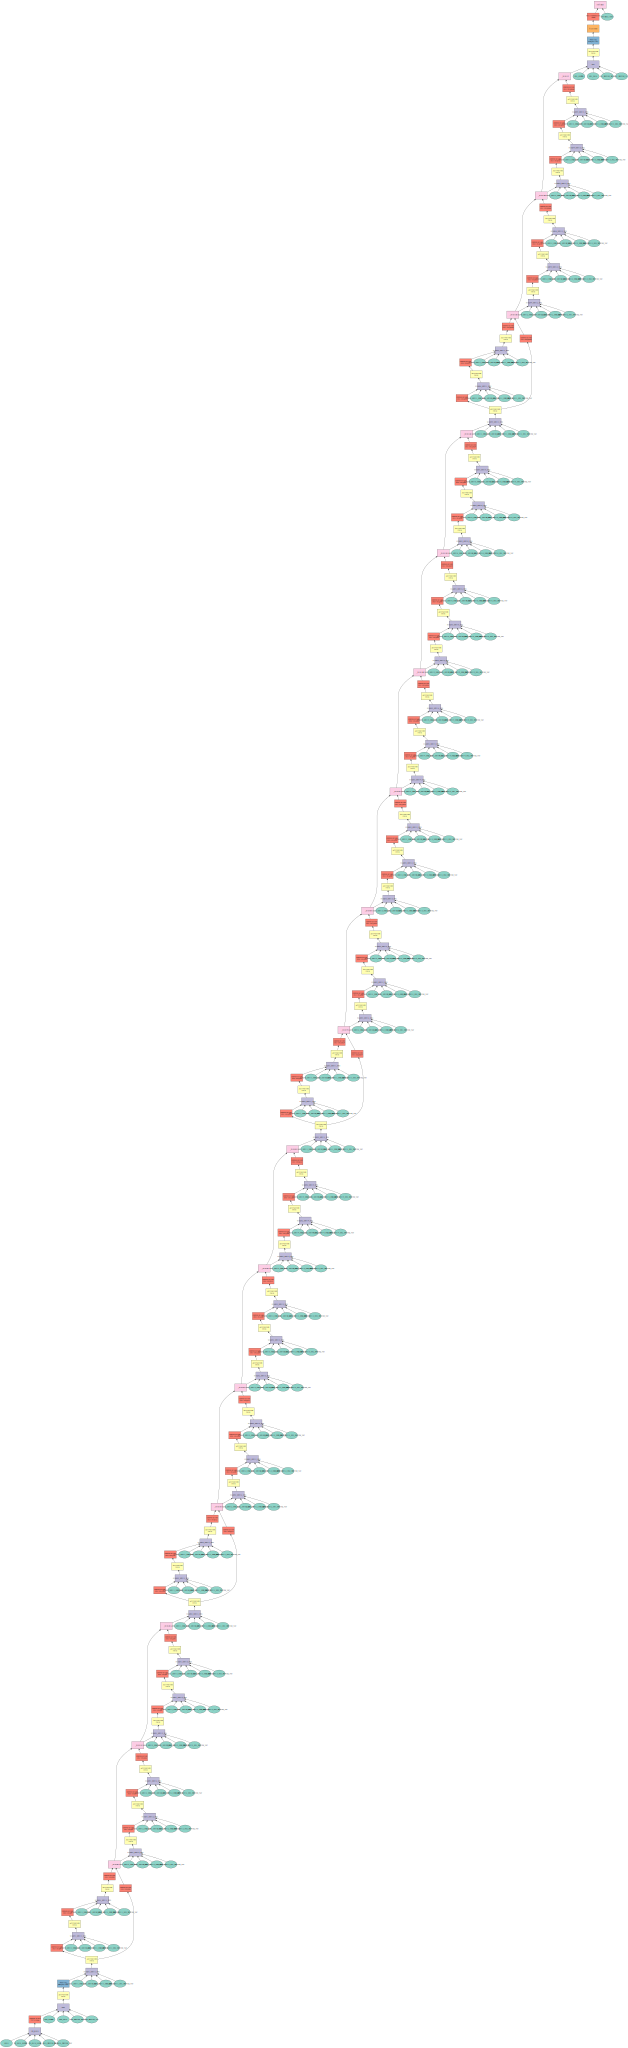

In [4]:
sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-50', 0)
mx.viz.plot_network(sym)

In [8]:
def get_resnet():
    net = import_module('resnet')
    sym = net.get_symbol(10,20,"3,28,28")
    return sym 
sym = get_resnet()

In [5]:
arg_params

{'bn0_beta': <NDArray 64 @cpu(0)>,
 'bn0_gamma': <NDArray 64 @cpu(0)>,
 'bn1_beta': <NDArray 2048 @cpu(0)>,
 'bn1_gamma': <NDArray 2048 @cpu(0)>,
 'bn_data_beta': <NDArray 3 @cpu(0)>,
 'bn_data_gamma': <NDArray 3 @cpu(0)>,
 'conv0_weight': <NDArray 64x3x7x7 @cpu(0)>,
 'fc1_bias': <NDArray 1000 @cpu(0)>,
 'fc1_weight': <NDArray 1000x2048 @cpu(0)>,
 'stage1_unit1_bn1_beta': <NDArray 64 @cpu(0)>,
 'stage1_unit1_bn1_gamma': <NDArray 64 @cpu(0)>,
 'stage1_unit1_bn2_beta': <NDArray 64 @cpu(0)>,
 'stage1_unit1_bn2_gamma': <NDArray 64 @cpu(0)>,
 'stage1_unit1_bn3_beta': <NDArray 64 @cpu(0)>,
 'stage1_unit1_bn3_gamma': <NDArray 64 @cpu(0)>,
 'stage1_unit1_conv1_weight': <NDArray 64x64x1x1 @cpu(0)>,
 'stage1_unit1_conv2_weight': <NDArray 64x64x3x3 @cpu(0)>,
 'stage1_unit1_conv3_weight': <NDArray 256x64x1x1 @cpu(0)>,
 'stage1_unit1_sc_weight': <NDArray 256x64x1x1 @cpu(0)>,
 'stage1_unit2_bn1_beta': <NDArray 256 @cpu(0)>,
 'stage1_unit2_bn1_gamma': <NDArray 256 @cpu(0)>,
 'stage1_unit2_bn2_beta': 

In [5]:
# 1. data reading
# labels in order: 
"""
0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck
"""

def get_cifar():
    # TODO fill all the blanks 
    # Hint
    # rgb mean default: '123.68,116.779,103.939',
    # pad size: whatever you think is valid, pad to 32 is good 
    # image shape:  the image shape feed into the network, e.g. (3,224,224)')
    # num-classes: the number of classes
    # num-examples:  the number of training examples, 50000 :)
    # data-nthreads: default=4,number of threads for data decoding, how many cpus do you have
    # dtype: default is float32, can be data type: float32 or float16')
    train = mx.io.ImageRecordIter(
            path_imgrec         = "cifar10_train.rec",
            label_width         = 1,
            mean_r              = 123.68,
            mean_g              = 116.779,
            mean_b              = 103.939,
            data_name           = 'data',
            label_name          = 'softmax_label',
            data_shape          = (3,28,28),
            batch_size          = 100,
            pad                 = 4,
            fill_value          = 127,
            #preprocess_threads  = ,
            shuffle             = True)
    val = mx.io.ImageRecordIter(
            path_imgrec         = "cifar10_val.rec",
            label_width         = 1,
            mean_r              = 123.68,
            mean_g              = 116.779,
            mean_b              = 103.939,
            data_name           = 'data',
            label_name          = 'softmax_label',
            data_shape          = (3,28,28),
            batch_size          = 100,
            pad                 = 4,
            fill_value          = 127,
            #preprocess_threads  = ,
            shuffle             = False)
    return train, val

train, val = get_cifar()
print(type(train))
print(type(val))
i = 0
for each in train:
    i += 1
    if i >3:
        break
    print each
# TODO write the script to look what is inside train and val
# Check the image size, and label 
# Question? check MXNET_course/mxnet-week3/cifar10/step_by_step_debug.ipynb

<class 'mxnet.io.MXDataIter'>
<class 'mxnet.io.MXDataIter'>
DataBatch: data shapes: [(100L, 3L, 28L, 28L)] label shapes: [(100L,)]
DataBatch: data shapes: [(100L, 3L, 28L, 28L)] label shapes: [(100L,)]
DataBatch: data shapes: [(100L, 3L, 28L, 28L)] label shapes: [(100L,)]


In [14]:
# Get the data iterator
train_iter, val_iter = get_cifar()

# create a trainable module on CPU/GPU
mod = mx.mod.Module(context=[mx.cpu()],
                        symbol=sym,
                        data_names=['data'],
                        label_names=['softmax_label'])
mod.bind(train_iter.provide_data,train_iter.provide_label)
mod.init_params(mx.init.Xavier(magnitude=2.0)) 
mod.init_optimizer('sgd',optimizer_params=(('learning_rate', 0.1), )) 
# run forward perdiction
# metric = mx.metric.create('acc')
# for epoch in range(1):
#     train_iter.reset()
#     metric.reset()
#     for batch in train_iter:
#         mod.forward(batch, is_train=True)
#         mod.update_metric(metric, batch.label)
#         mod.backward()
#         mod.update()
#     print ('Epoch {}, Train {}'.format(epoch, metric.get()))
mod.fit(train_iter,  # train data
       eval_data=val_iter,  # validation data
       optimizer='sgd',  # use SGD to train
       optimizer_params={'learning_rate': 0.1},  # use fixed learning rate
       eval_metric='acc',  # report accuracy during training
       batch_end_callback=mx.callback.Speedometer(100, 100),
       # output progress for each 100 data batches
       num_epoch=1)  # train for at most 10 dataset passes

/Users/Xin/mxnet/lib/python2.7/site-packages/mxnet/module/base_module.py:463: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)
